# Netflix Stock Price Evaluation (SARIMAX model)

On this project, we are going to create an SARIMAX model to predict the Netflix stock price using the historical data.

SARIMA model stands for seasonal autoregressive integrated moving average model, which is specified by seven order parameters: (p, d, q)x(P, D, Q, S). Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors and it is an extension of the SARIMA class model.

In [27]:
# Load the required libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data 

dat = pd.read_csv('NFLX.csv', index_col ='Date', parse_dates = True)

In [3]:
# Explore the data

dat.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [4]:
# Drop missing values, if any

df = dat.dropna()

In [5]:
# Get the trading days 

df.shape

(4797, 6)

There are 4797 trading days.

In [6]:
# Split the train data and test data(last 122 data points)

training_set = df.iloc[:4675, ]
test_set = df.iloc[4675:, ]

## SARIMA Model for Time Series Forecasting:

In [7]:
# Importing required libraries

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

### ETS Decomposition:

ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend, and Seasonality. 

In [8]:
# ETS Decomposition

result = seasonal_decompose(training_set['Close'], model ='multiplicative', freq=253)

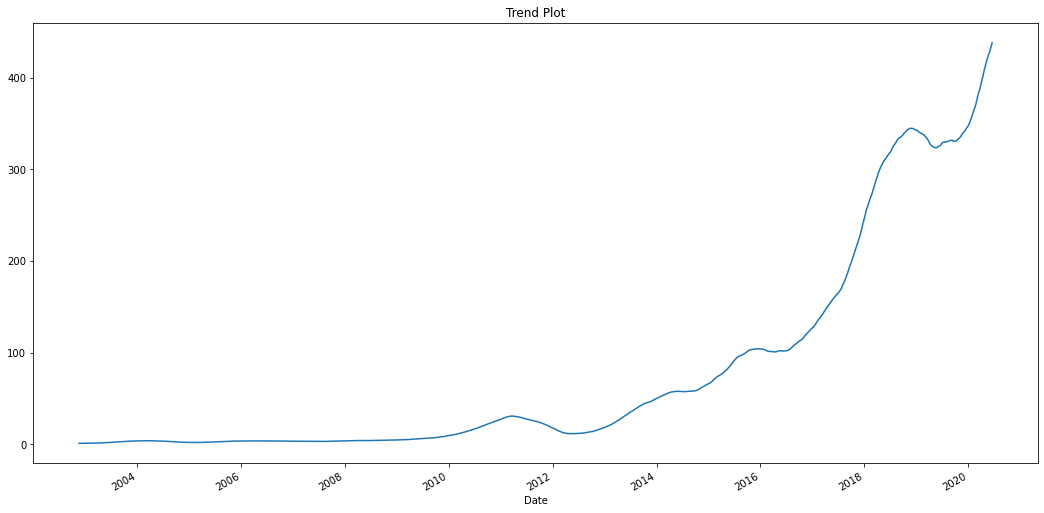

In [9]:
# Trend plot for Netfilx Stock Price(Close)

plt.figure(figsize = (18,9))
result.trend.plot()
plt.title("Trend Plot");

This is the trend plot for historical Netflix stock price(Close price). We can see an increasing trend with some flucations from 5/23/2002 to 6/11/2021.

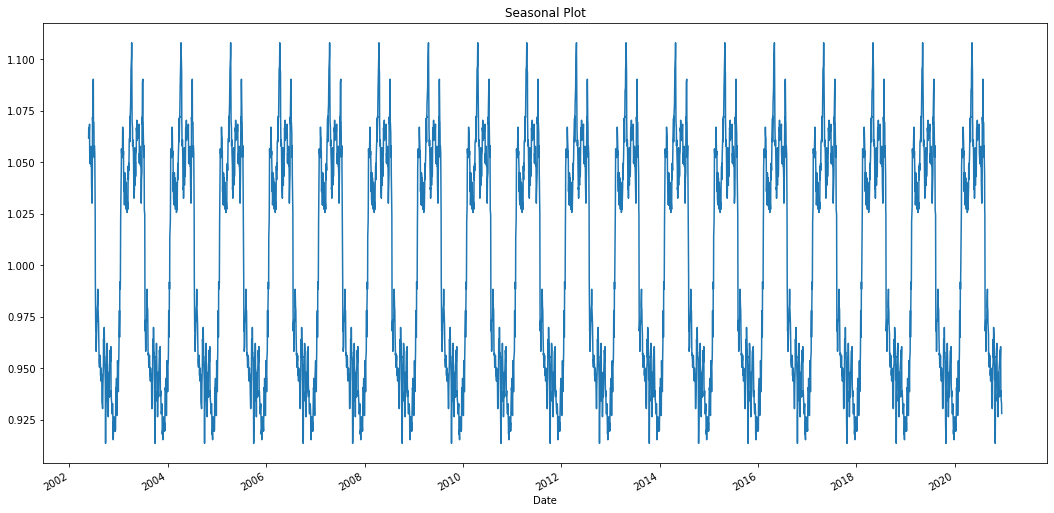

In [10]:
# Seasonal plot for Netfilx Stock Price(Close)

plt.figure(figsize = (18,9))
result.seasonal.plot()
plt.title("Seasonal Plot");

This is the seasonality plot for historical Netflix stock price(Close price). We can see there is an obvious yearly seasonality in this data set. Therefore, we will use S=12 later when fitting the SARIMA model.

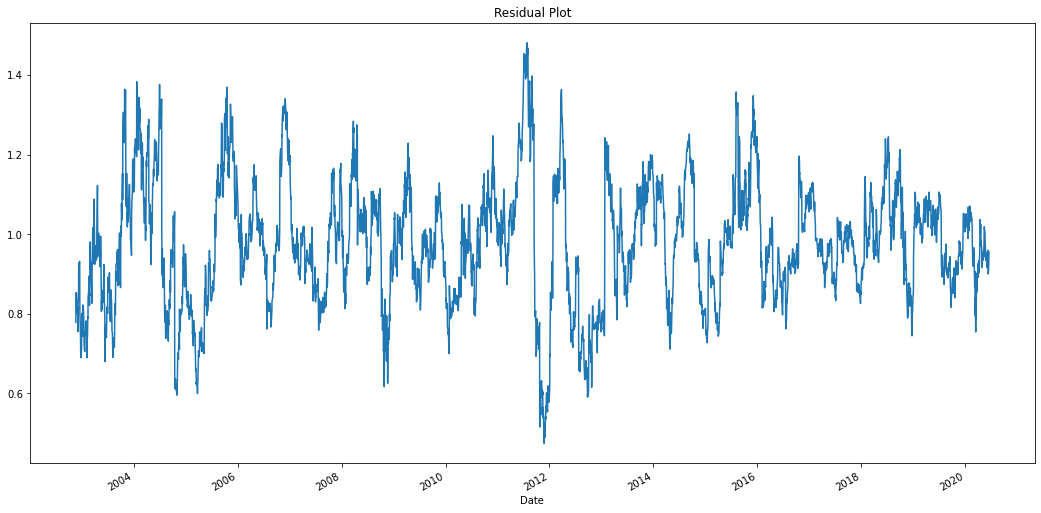

In [11]:
# Residual plot for Netfilx Stock Price(Close)

plt.figure(figsize = (18,9))
result.resid.plot()
plt.title("Residual Plot");

From this residual plot, we can see it is approximately homoscedastic. Since residuals are roughly robust, we can fit a SRIMA model for the residuals.

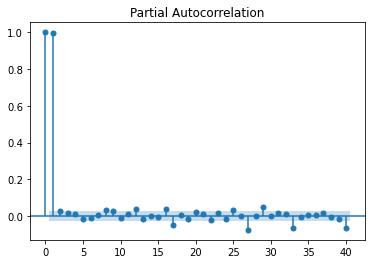

In [12]:
# Partial Autocorrelation function(PACF) graph

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(training_set['Close'].values.squeeze(), lags=40)
plt.show()

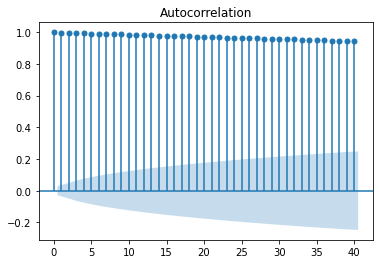

In [13]:
# Autocorrelation function(ACF) graph

sm.graphics.tsa.plot_acf(training_set['Close'].values.squeeze(), lags=40)
plt.show()

From the PACF and ACF plots above, we can see there are two significant magnitudes in the PACF plot. This observation suggests that p=2 might be a potential fit for the model.

In [28]:
# Fit SARIMAX Model

from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(training_set['Close'], 
                order = (2, 0, 0), 
                seasonal_order =(0, 1, 0, 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 4675
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood              -14661.080
Date:                            Thu, 17 Jun 2021   AIC                          29328.160
Time:                                    22:41:45   BIC                          29347.502
Sample:                                         0   HQIC                         29334.963
                                           - 4675                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8486      0.006    137.304      0.000       0.836       0.861
ar.L2          0.0571      0.006      9.496      0.000       0.045       0.069
sigma2        31.4973      0.177    178.379      0.000      31.151      31.843
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):            124434.84
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):            3343.18   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the summary, we can tell this model is pretty reasonable, since the p-values are significant.

In [29]:
# Predicted values from the last 122 data points

start = len(training_set)
end = len(training_set) + len(test_set) - 1

predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

In [16]:
print('Prediction for the 122 data points starting from 12/16/2020:')
predictions

Prediction for the 122 data points starting from 12/16/2020:


4675    516.953821
4676    528.481512
4677    525.161720
4678    517.368535
4679    516.397034
           ...    
4792    520.127591
4793    537.827060
4794    533.819761
4795    529.747557
4796    540.139831
Name: Predictions, Length: 122, dtype: float64

In [17]:
# Calculate the root mean square error(rmse)

rmse_arima = (np.mean((test_set['Close'].values - predictions) ** 2)) ** 0.5
print('RMSE for the SARIMA model:')
rmse_arima

RMSE for the SARIMA model:


25.43482348470979

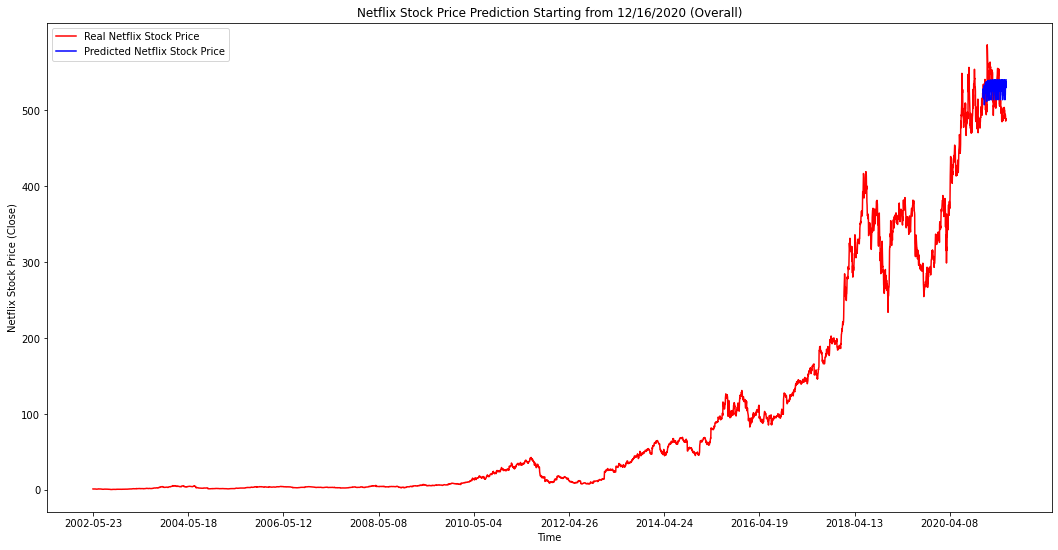

In [18]:
# Visualize the results(Real vs. Predicted)
# Real Netfilx stock price in red, and predicted stock price in blue

plot_dat = pd.read_csv('NFLX.csv')
plt.figure(figsize = (18,9))
plt.plot(plot_dat.loc[:, 'Date'],plot_dat.iloc[:, 4:5].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(plot_dat.loc[4675:, 'Date'],predictions, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.yticks(np.arange(0,600,100))
plt.xticks(np.arange(0,4797,500))
plt.title('Netflix Stock Price Prediction Starting from 12/16/2020 (Overall)')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

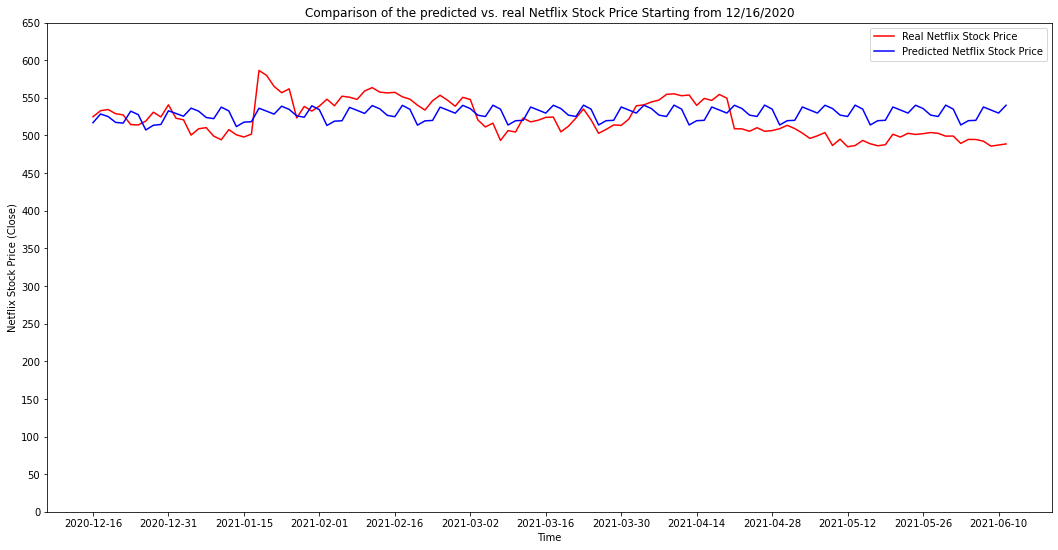

In [19]:
# Comparison of the predicted vs. real Netflix Stock Price

plt.figure(figsize = (18,9))
plt.plot(plot_dat.loc[4675:, 'Date'],plot_dat.iloc[4675:, 4:5].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(plot_dat.loc[4675:, 'Date'],predictions, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.xticks(np.arange(0,122,10))
plt.yticks(np.arange(0,700,50))
plt.title('Comparison of the predicted vs. real Netflix Stock Price Starting from 12/16/2020')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

In this plot, we can see the predicted values are pretty close to the real values. The RMSE is also pretty small, which is 25.43.

## Predictions for the next 10 trading days


In [30]:
# Fit the SARIMAX model for the entire dataset

final_arima_model = SARIMAX(df['Close'], 
                order = (2, 0, 0), 
                seasonal_order =(0, 1, 0, 12))
  
result_arima = final_arima_model.fit()
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 4797
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood              -15486.221
Date:                            Thu, 17 Jun 2021   AIC                          30978.441
Time:                                    22:41:58   BIC                          30997.861
Sample:                                         0   HQIC                         30985.263
                                           - 4797                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8485      0.007    128.990      0.000       0.836       0.861
ar.L2          0.0461      0.006      7.234      0.000       0.034       0.059
sigma2        37.8847      0.206    184.314      0.000      37.482      38.288
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            149484.41
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):            3954.07   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Prediction for the next ten days

forecast = result_arima.get_forecast(10)
  
pred_close = forecast.predicted_mean
pred_close

4797    490.973730
4798    493.619277
4799    493.595854
4800    490.789692
4801    491.780906
4802    482.718780
4803    488.701664
4804    489.227099
4805    487.501830
4806    481.411918
Name: predicted_mean, dtype: float64

In [22]:
# Calculate the 95% confidence interval for the predictions

conf = forecast.conf_int()

In [23]:
for_10_arima = pd.DataFrame()
for_10_arima['Close'] = pred_close
date = ['2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25']
for_10_arima['Date'] = date
for_10_arima = for_10_arima[["Date", "Close"]]
for_10_arima['Lower Interval'] = conf['lower Close']
for_10_arima['Upper Interval'] = conf['upper Close']
print("Next 10 Days' Netflix Stock Prediction")
for_10_arima

Next 10 Days' Netflix Stock Prediction


,Date,Close,Lower Interval,Upper Interval
4797,2021-06-14,490.973730,478.910050,503.037410
4798,2021-06-15,493.619277,477.798469,509.440086
4799,2021-06-16,493.595854,475.273905,511.917804
4800,2021-06-17,490.789692,470.670126,510.909259
4801,2021-06-18,491.780906,470.316073,513.245738
4802,2021-06-21,482.718780,460.223767,505.213792
4803,2021-06-22,488.701664,465.406037,511.997290
4804,2021-06-23,489.227099,465.302969,513.151229
4805,2021-06-24,487.501830,463.080755,511.922906
4806,2021-06-25,481.411918,456.595839,506.227996


In [24]:
# Combine the entire data set with the prediction

result = pd.concat([plot_dat, for_10_arima], axis=0, join="inner")

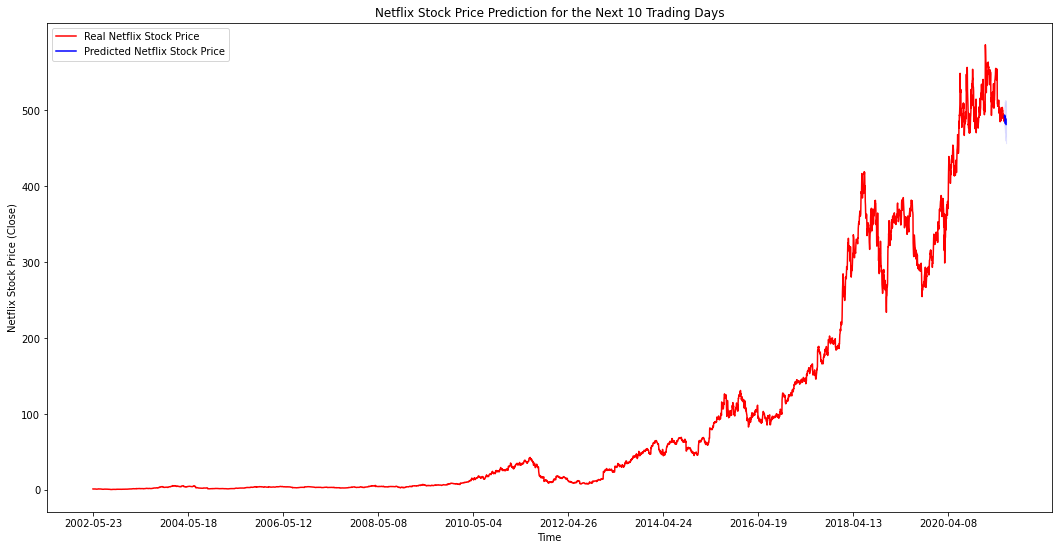

In [25]:
# Visualize the prediction results with 95% confidence interval

plt.figure(figsize = (18,9))
plt.plot(result.loc[:4797, 'Date'],result.loc[:4797, 'Close'].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(result.loc[4797:, 'Date'],result.loc[4797:, 'Close'].values, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.fill_between(result.loc[4797:, 'Date'], for_10_arima.loc[4797:, 'Lower Interval'].values, for_10_arima.loc[4797:, 'Upper Interval'].values, color='blue', alpha=0.1)
plt.yticks(np.arange(0,600,100))
plt.xticks(np.arange(0,4807,500))
plt.title('Netflix Stock Price Prediction for the Next 10 Trading Days')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

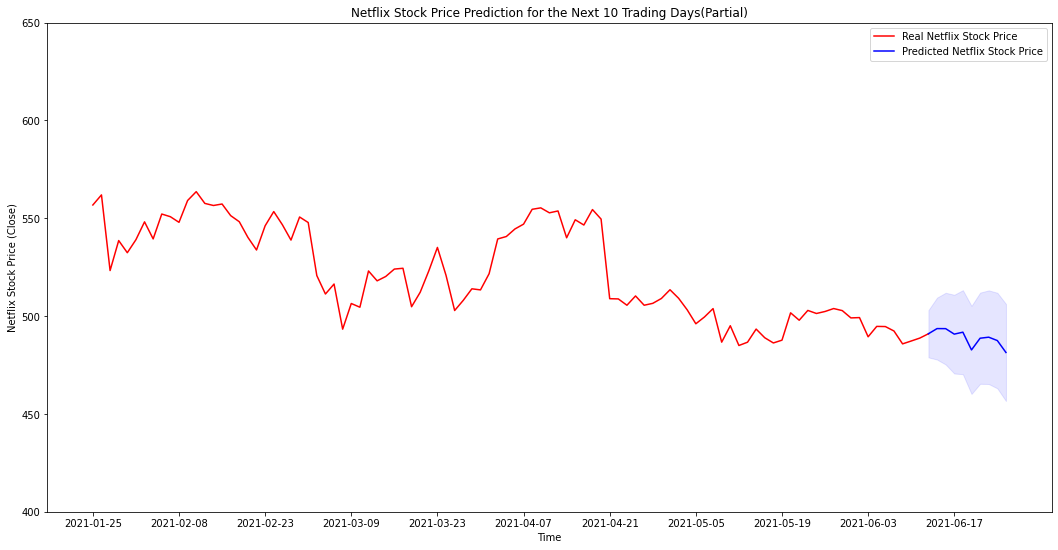

In [27]:
# Visualize the prediction results

plt.figure(figsize = (18,9))
plt.plot(result.loc[4700:4797, 'Date'],result.loc[4700:4797, 'Close'].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(result.loc[4797:, 'Date'],result.loc[4797:, 'Close'].values, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.fill_between(result.loc[4797:, 'Date'], for_10_arima.loc[4797:, 'Lower Interval'].values, for_10_arima.loc[4797:, 'Upper Interval'].values, color='blue', alpha=0.1)
plt.yticks(np.arange(400,700,50))
plt.xticks(np.arange(0,107,10))
plt.title('Netflix Stock Price Prediction for the Next 10 Trading Days(Partial)')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()